# **Final Project, Machine Learning 2020**

> Diego Useche Reyes, diusecher@unal.edu.co

> Sneyder Gantiva, esgantivar@unal.edu.co

Advisor, PhD Fabio A. Gonzalez



## Abstract

There is an increasing need for more robust, efficient and with less complexity algorithms in Machine Learning. In the following  work  we  present  a  modern  approach  to  ML  based  on Tensor Networks, which have been historically applied to physics and  more  recently  to  machine  learning.  The  aim  of  the  present article  is  to  show  how  to  do  supervised  learning  of  images  and texts  with  the  MPS  Tensor  Network,  we  apply  this  network  to three data sets of images and texts; the MNIST data set, a dataset  of  Spanish  and  English  words,  and  the  Multimodal  IMDb(MM-IMDb)  dataset.

## References

[TensorNetwork for Machine Learning](https://arxiv.org/pdf/1906.06329.pdf)

[Supervised Learning With Quantum-Inspired Tensor Networks](https://arxiv.org/pdf/1605.05775.pdf)

[Mobilenet Feature Extraction](https://www.kaggle.com/gopalrahulrg/mobilenet-feature-extraction)

[Gated multimodal units for information fusion](https://arxiv.org/pdf/1702.01992.pdf)

## Link Video poster

* [Link Youtube](https://youtu.be/inJ0S1eHGPU)

* [Link Google Drive](https://drive.google.com/file/d/1dC-A_hgwZRw5HMGiwDYfSHVL_kX29U4E/view?usp=sharing)

In [ ]:
# Setup the GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Mount Google Drive

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/ml/mmimdb_mps_vgg16_128_128_3.hdf5" .

## Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
from time import time

In [ ]:
%%time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential

print(tf.__version__)
print(tf.config.list_logical_devices())

2.2.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]
CPU times: user 15 ms, sys: 9.73 ms, total: 24.7 ms
Wall time: 151 ms


In [ ]:
# from fuel.datasets import H5PYDataset
!pip install git+git://github.com/mila-udem/fuel.git
from fuel.datasets.hdf5 import H5PYDataset

  Cloning git://github.com/mila-udem/fuel.git to /tmp/pip-req-build-7buy4sa6
  Running command git clone -q git://github.com/mila-udem/fuel.git /tmp/pip-req-build-7buy4sa6
  Created wheel for fuel: filename=fuel-0.2.0-cp36-cp36m-linux_x86_64.whl size=388256 sha256=dc89f159a10a06dd26bb83d7e3f17a72a2cb856202c958bd432a1c6df1b78ed9
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2lpi85y/wheels/f4/82/90/806cc19722961b5dce092732e97da11e470732a707ad263f9c
  Created wheel for picklable-itertools: filename=picklable_itertools-0.1.1-cp36-none-any.whl size=15591 sha256=1cd7acf8482da6002900c76890ccc8582bde02b53623f7c7e5319fd2ff0affb3
  Stored in directory: /root/.cache/pip/wheels/36/dd/e2/ec30ef7c475e1d9fb966735984ba05f8710c67d7de5358c326
Successfully built fuel picklable-itertools


## Utils Functions

In [ ]:
def plot_and_save_loss(history, title, name = 'model_loss', save = False):
    '''
    history: dict,
    title: title of plot,
    name: name of file
    '''
    plt.plot(history['loss'], label='loss')
    plt.title(title)
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if save == True:
      plt.savefig(f"/notebooks/storage/histories/plots/{name}.pdf")

In [ ]:
def plot_and_save_accuracy(history, title, name = 'model_acc', save = False):
    '''
    history: dict,
    title: title of plot,
    name: name of file
    '''
    plt.plot(history['accuracy'], label='accuracy')
    plt.title(title)
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if save == True:
      plt.savefig(f"/notebooks/storage/histories/plots/{name}.pdf")

In [ ]:
# evaluates the multilabel model over a data set returning the 4 types of f-scores
def evaluate_model(X_p, y_p, model_p = model):
  # compute the prediction of the model
  y_pred = model_p.predict(X_p)
  y_pred[y_pred>=0.5] = 1
  y_pred[y_pred<0.5] = 0

  # compute the 4 types of f scores
  f_macro = f1_score(y_p, y_pred, average='macro').round(3)
  f_micro = f1_score(y_p, y_pred, average='micro').round(3)
  f_weighted = f1_score(y_p, y_pred, average='weighted').round(3)
  f_samples = f1_score(y_p, y_pred, average='samples').round(3)

  return (f_macro, f_micro, f_weighted, f_samples)

## CreateDatset class

The following class are used to pre process poster data of MM-IMDb

In [ ]:
class CreateDataset:
    _from = None
    _to = None
    
    _train_names = None
    _dev_names = None
    _validation_names = None
    
    
    _target_size = (128, 128)
    BASE_PATH = None
    
    def __init__(self, from_path='multimodal_imdb', to_path='mmimdb_mps_mnet_128', BASE_PATH='/notebooks/storage/mmimdb'):
        self.from_path = f"/notebooks/storage/{from_path}.hdf5"
        self.to_path = f"/notebooks/storage/mps/{to_path}.hdf5"
        self.BASE_PATH = BASE_PATH
        
    def open_from(self, mode='r'):
        self._from = h5py.File(self.from_path, mode=mode)
        
    def open_to(self, mode='r'):
        print(self.to_path)
        self._to = h5py.File(self.to_path, mode=mode)
    
    def close_to(self):
        self._to.flush()
        self._to.close()
        
    def get_path(self, path):
        return f'{self.BASE_PATH}/dataset/{path}'
    
    def preprocess(self):
        sets = [
            {
                'key': 'dev',
                'X': 'dev_images',
                'Y': 'dev_target'
            },
            {
                'key': 'test',
                'X': 'test_images',
                'Y': 'test_target'
            },            
            {
                'key': 'train',
                'X': 'train_images',
                'Y': 'train_target'
            }
        ]
        self.open_to(mode='w')
        try:
            for item in sets:
                names = H5PYDataset(self.from_path, which_sets=(item['key'],), sources = ['imdb_ids'], load_in_memory=True)
                X = np.empty((names.num_examples,self._target_size[0], self._target_size[1],3))
                num_examples = names.num_examples
                #X = np.empty((num_examples,self._target_size[0], self._target_size[1],3))
                print(f"init {item['key']}: {names.num_examples}")
                for i in range(names.num_examples): 
                    name = names.data_sources[0][i].decode('utf-8')
                    X[i] = self._prepare_image(name)
                    if i % 1000 == 0:
                        print(i)
                print(X.shape)
                self._to.create_dataset(item['X'], data=X)
                self._to.flush()
                self._to.create_dataset(item['Y'], data=H5PYDataset(self.from_path, which_sets=(item['key'],), sources = ['genres'], load_in_memory=True).data_sources[0])
                self._to.flush()
                print(f"end {item['key']}")

            self._to.close()
        except ValueError:
            print(e)
            self._to.close()
            print('error')
    
    def _prepare_image(self, name):
        try:
            image_path = self.get_path(f"{name}.jpeg")
            img = load_img(image_path, target_size=self._target_size)
            img_array = img_to_array(img)
            return preprocess_input(img_array)
        except ValueError:
            print(name)
            return None

## MPS Class

Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
class MPSLayer(layers.Layer):

    def __init__(self, n_sites, d_bond, n_output, dim=2, dtype=tf.float32):
        super(MPSLayer, self).__init__()
        if n_sites % 2:
            raise NotImplementedError("Number of sites should be even but is "
                                      "{}.".format(n_sites))

        self.n_half = n_sites // 2
        self.dim = dim
        self.left = tf.Variable(self._initializer(self.n_half, self.dim, d_bond),
                                dtype=dtype, trainable=True)
        self.right = tf.Variable(self._initializer(self.n_half, self.dim, d_bond),
                                 dtype=dtype, trainable=True)
        self.middle = tf.Variable(self._initializer(n_output, 1, d_bond)[0],
                                  dtype=dtype, trainable=True)

    @staticmethod
    def _initializer(n_sites, d_phys, d_bond):
        w = np.stack(d_phys * n_sites * [np.eye(d_bond)])
        w = w.reshape((d_phys, n_sites, d_bond, d_bond))
        return w + np.random.normal(0, 1e-2, size=w.shape)

    def call(self, inputs):
        with tf.name_scope('call'):
            left = tf.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])
            right = tf.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])
            left = self.reduction(left)
            right = self.reduction(right)
            aux = tf.einsum("bij,cjk,bki->bc", left, self.middle, right)
        return aux

    @staticmethod
    def reduction(tensor):
        with tf.name_scope('reduction'):
            size = int(tensor.shape[0])
            while size > 1:
                half_size = size // 2
                nice_size = 2 * half_size
                leftover = tensor[nice_size:]
                tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
                tensor = tf.concat([tensor, leftover], axis=0)
                size = half_size + int(size % 2 == 1)
        return tensor[0]
    
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Quantum Feature Maps

Binary Pixel Feature Map

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# Preprocess data function
def preprocess_images(x):
  n_data, dim0, dim1 = tuple(x.shape)
  n_sites = dim0 * dim1
  x = x.reshape((n_data, n_sites)) / 255
  x = tf.cast(tf.math.greater(x, 0.5), dtype=tf.int32)
  return tf.keras.utils.to_categorical(x, 2)

Stoudenmire Feature Map

In [ ]:
'''
Based on the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
def preprocess_stoudenmire(x):
  n_data, dim0, dim1 = tuple(x.shape)
  n_sites = dim0 * dim1
  x = (x.reshape((n_data, n_sites)) / 255) * (np.pi/2)
  sin = tf.math.sin(x)
  cos = tf.math.cos(x)
  #return tf.cast(tf.stack([cos, sin], axis=2), dtype=tf.float32).numpy()
  return tf.cast(tf.stack([cos, sin], axis=2), dtype=tf.float32)

N-gram Feature Map

In [ ]:
'''
Based on the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# given a matrix of n-grams vectors , convert to a quantum feature map 
def preprocess_words(x):
  n_data, n_sites = tuple(x.shape)
  x = x.todense()
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  x = tf.cast(tf.math.greater(x, 0.5), dtype=tf.int32)
  return tf.keras.utils.to_categorical(x, 2)

Tfidf Feature Map

In [ ]:
'''
Based on the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# Find the average value of non zero values of the Tifdf vector, choose ket(0)
# for values below the average ket(1) for n-grams above the average
def preprocess_words(X_p):
  n_data, n_sites = tuple(X_p.shape)
  #x = x.todense()
  average = X_p.sum(axis=1)/np.count_nonzero(X_p, axis=1)
  average = tf.convert_to_tensor(average, dtype=tf.float32)
  average = tf.keras.backend.reshape(average, shape=(-1, 1))
  X_p = tf.convert_to_tensor(X_p, dtype=tf.float32)
  X_p = tf.cast(tf.math.greater(X_p, average), dtype=tf.int32)
  return tf.keras.utils.to_categorical(X_p, 2)

## MPS for Visual Classification

### MNIST Classification

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
#Extract the MNIST Images and preprocess
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
# convert images to supported format
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 784, 2), (60000, 10), (10000, 784, 2), (10000, 10))

#### Binary Pixel Feature Map

In [ ]:
# Model Parameters
batch_size = 64
num_classes = 10
epochs = 100
d_bond = 10 # for MPS
num_exps = 30 

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# Define model
n_sites = x_train.shape[1]
model = Sequential()
model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
model.add(layers.Softmax())


# Compile and run
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

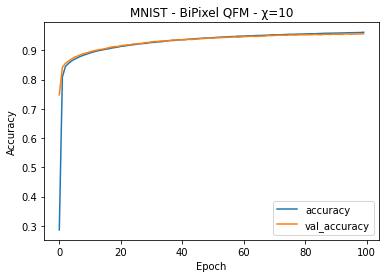

In [ ]:
plot_and_save_accuracy(history.history, 'MNIST - BiPixel QFM - χ=10')

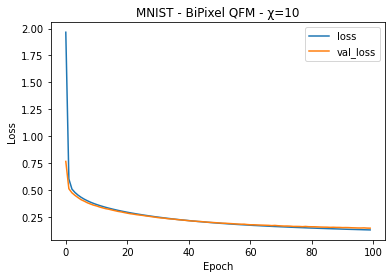

In [ ]:
plot_and_save_loss(history.history, 'MNIST - BiPixel QFM - χ=10')

In [ ]:
score_train = model.evaluate(x_train, y_train, verbose=0)

score_train[1]

0.962149977684021

#### Bond Parameter Tunning

In [ ]:
# Model Parameters
batch_size = 64
num_classes = 10
epochs = 100
d_bond = 10 # for MPS
num_exps = 30 

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
bonds = [60]
train_acc = []
test_acc = []
for d_bond in bonds:
  init_time = time()
  # Define model
  n_sites = x_train.shape[1]
  model = Sequential()
  model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
  model.add(layers.Softmax())


  # Compile and run
  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))
  score_train = model.evaluate(x_train, y_train, verbose=0)
  score_test = model.evaluate(x_test, y_test, verbose=0)

  print('Bond:', d_bond)
  print('Train accuracy:', score_train[1])
  train_acc.append(score_train[1])
  print('Test accuracy:', score_test[1])
  test_acc.append(score_test[1])
  print(time()-init_time)

In [ ]:
train_acc, test_acc

([1.0], [0.9645000100135803])

Summary of the results of the Bond Parameter tunning in MNIST

In [ ]:
# summary of the results of bond parameter tunning
bonds = [10, 20, 30, 40, 50, 60]
train_acc_results = [0.962149977684021, 0.9840166568756104, 0.9963499903678894, 0.9999833106994629, 1.0, 1.0]
test_acc_results = [0.9567000269889832, 0.9661999940872192, 0.9682999849319458, 0.9666000008583069, 0.96670001745224, 0.9645000100135803]

train_acc_results, test_acc_results

([0.962149977684021,
  0.9840166568756104,
  0.9963499903678894,
  0.9999833106994629,
  1.0,
  1.0],
 [0.9567000269889832,
  0.9661999940872192,
  0.9682999849319458,
  0.9666000008583069,
  0.96670001745224,
  0.9645000100135803])

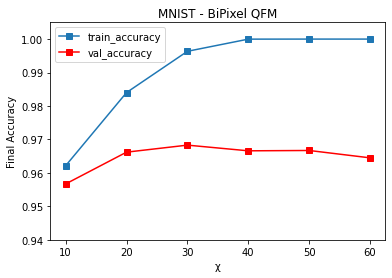

In [ ]:
# plot of the results of bond parameter tuning
plt.plot( bonds, train_acc_results, label='train_accuracy', marker = 's')
plt.title('MNIST - BiPixel QFM')
plt.plot( bonds, test_acc_results, label='val_accuracy', color='red', marker='s')
plt.legend()
plt.ylim(0.94, 1.005)
plt.xlabel('χ')
plt.ylabel('Final Accuracy')

### MM-IMDb Poster Classification

#### Feature Extraction

In practice, very few people train an entire Convolutional Network from scratch because this task need an huge train dataset and involve have big computational resources.

The idea of feature extraction is use a pre trained CNN to extract some features that we have not explicit in the data.

We propose use VGG16 CNN to process the raw data, the images are pre processed to (128,128,3) dimension. After feature extraction we apply a modification of **Binary Pixel Feature Map**, on this variation we use a sigmoid function to normalize the input data

**Feature Extraction**

In [ ]:
# Open pre processed images
hf = h5py.File('/notebooks/storage/mps/mmimdb_mps_mnet_128.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

In [ ]:
# Load CNN without top layer
pre_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in pre_model.layers:
    layer.trainable = False
pre_model.summary()

Using pre-model, apply predict over pre processed images. The result of prediction are flatten for create a site of MPS.

The result of this are saved on h5py dataset

In [ ]:
features_mnet = h5py.File('storage/mps/features/vg16.h5py', mode='w')
for key in ['dev', 'train', 'test']:
    features = model.predict(hf[f'{key}_images'], batch_size=64)
    flatten = features.reshape((features.shape[0], features.shape[1] * features.shape[2] * features.shape[3]))
    features_mnet.create_dataset(f'{key}_images', data=flatten)
    features_mnet.flush()
    features_mnet.create_dataset(f'{key}_target', data=hf[f'{key}_target'][()])
    features_mnet.flush()
features_mnet.close()

> **Feature Map**

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def binary_feature_map(X):
    x = sigmoid(X)
    x = tf.cast(tf.math.greater(X, 0.5), dtype=tf.int32)
    return tf.keras.utils.to_categorical(x,2)

Open dataset with extracted features

In [ ]:
hf = h5py.File('/notebooks/storage/mps/features/vg16.h5py','r')
dataset_names = list(hf.keys())
dataset_names

In [ ]:
X_dev = binary_feature_map(hf['dev_images'][()])
X_test = binary_feature_map(hf['test_images'][()])
X_train = binary_feature_map(hf['train_images'][()])

X_train.shape, X_dev.shape, X_test.shape

In [ ]:
Y_dev = hf['dev_target'][()]
Y_test = hf['test_target'][()]
Y_train = hf['train_target'][()]

Y_train.shape, Y_dev.shape, Y_test.shape

> **Experiments**

In [ ]:
batch_size = 64
num_classes = 23
epochs = 100

Create a model

In [ ]:
for d_bond in [5, 10, 15, 20, 25, 30]:
    print(f'init d_bond: {d_bond}')
    n_sites = X_train.shape[1]
    model = Sequential()
    model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
    model.add(layers.Activation(activations.sigmoid))


    # Compile and run
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_dev, Y_dev))
    model.save(f'storage/mps_pixel_vgg16_{d_bond}')
    save_history(history, name=f'history_vgg16_mps_{d_bond}')
    print(f'end d_bond: {d_bond}')

> **Loss value behavior on training proccess for diferents bond dimensions using Feature extraction from pre trained model VGG16** 

In [ ]:
h_5 = pd.read_json('/content/history_vgg16_mps_5.json')
h_10 = pd.read_json('/content/history_vgg16_mps_10.json')
h_15 = pd.read_json('/content/history_vgg16_mps_15.json')
h_20 = pd.read_json('/content/history_vgg16_mps_20.json')
h_25 = pd.read_json('/content/history_vgg16_mps_25.json')
h_30 = pd.read_json('/content/history_vgg16_mps_30.json')

Text(0, 0.5, 'Loss')

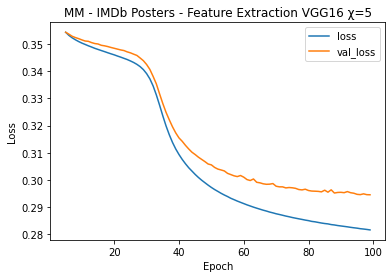

In [ ]:
interval = [ i for i in range(5)]
h_5 = h_5.drop(interval, axis=0)
plt.plot(h_5['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=5')
plt.plot(h_5['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

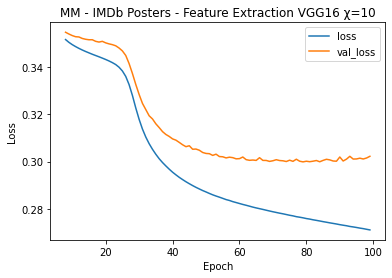

In [ ]:
interval = [ i for i in range(8)]
h_10 = h_10.drop(interval, axis=0)
plt.plot(h_10['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=10')
plt.plot(h_10['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

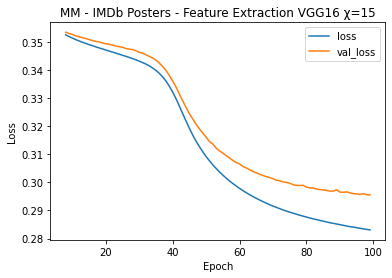

In [ ]:
interval = [ i for i in range(8)]
h_15 = h_15.drop(interval, axis=0)
plt.plot(h_15['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=15')
plt.plot(h_15['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

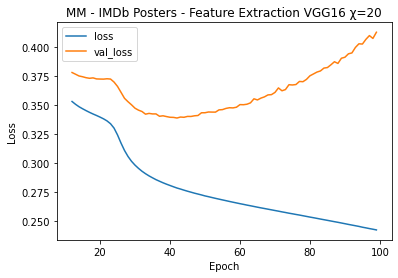

In [ ]:
interval = [ i for i in range(12)]
h_20 = h_20.drop(interval, axis=0)
plt.plot(h_20['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=20')
plt.plot(h_20['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

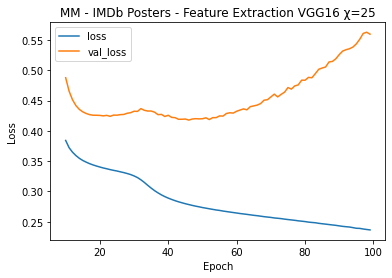

In [ ]:
interval = [ i for i in range(10)]
h_25 = h_25.drop(interval, axis=0)
plt.plot(h_25['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=25')
plt.plot(h_25['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

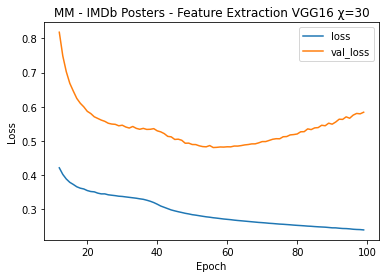

In [ ]:
interval = [ i for i in range(12)]
h_30 = h_30.drop(interval, axis=0)
plt.plot(h_30['loss'], label='loss')
plt.title('MM - IMDb Posters - Feature Extraction VGG16 χ=30')
plt.plot(h_30['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

> **Results**

The following table show f-score of experiments with hyperparameter *d_bond* variations. All experiments was runned with 100 epochs

<table>
    <thead>
    <tr>
        <th colspan="5">F-Score</th>
    </tr>
    <tr>
        <th>dataset</th>
        <th>macro</th>
        <th>micro</th>
        <th>weighted</th>
        <th>samples</th>
    </tr>
    </thead>
    <thead>
    <tr>
        <th colspan="5">χ=5</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0325</td>
        <td>0.2499</td>
        <td>0.1548</td>
        <td>0.2375</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.0294</td>
        <td>0.2243</td>
        <td>0.1398</td>
        <td>0.2123</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.0311</td>
        <td>0.2354</td>
        <td>0.1448</td>
        <td>0.2248</td>
    </tr>
    <thead>
    <tr>
        <th colspan="5">χ=10</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0385</td>
        <td>0.2673</td>
        <td>0.1743</td>
        <td>0.2446</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.0346</td>
        <td>0.2299</td>
        <td>0.1534</td>
        <td>0.2116</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.0362</td>
        <td>0.2323</td>
        <td>0.1536</td>
        <td>0.2146</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=15</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.033</td>
        <td>0.2485</td>
        <td>0.1548</td>
        <td>0.2334</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.0313</td>
        <td>0.2279</td>
        <td>0.1438</td>
        <td>0.2153</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.0329</td>
        <td>0.2364</td>
        <td>0.1495</td>
        <td>0.225</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=20</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0922</td>
        <td>0.3783</td>
        <td>0.2846</td>
        <td>0.3222</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.1097</td>
        <td>0.2553</td>
        <td>0.2368</td>
        <td>0.226</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.1106</td>
        <td>0.2547</td>
        <td>0.2424</td>
        <td>0.2275</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=25</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.1217</td>
        <td>0.4005</td>
        <td>0.3146</td>
        <td>0.335</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.1349</td>
        <td>0.2516</td>
        <td>0.2646</td>
        <td>0.22</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.1309</td>
        <td>0.2465</td>
        <td>0.2628</td>
        <td>0.2153</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=30</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.1185</td>
        <td>0.3806</td>
        <td>0.2936</td>
        <td>0.3181</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.1347</td>
        <td>0.236</td>
        <td>0.262</td>
        <td>0.2157</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.1328</td>
        <td>0.2354</td>
        <td>0.2612</td>
        <td>0.2168</td>
    </tr>
    </tbody>
</table>


We can see that a increase of bound dimensions improve the f-scores, however when we se the behavior of the loss function on the training process a increase on bound dimension also increase the loss value on validation dataset.

#### RGB to Grayscale Feature Map

The following feature map make a fusion of 3 channels (Red, Green and Blue) based on lightness. The weights of each channel are usually used in visual computation to generate grayscale images based on 3 channels. 

After fusion we apply **Binary Pixel feature Map** to generated grayscale image

In [ ]:
def preprocess_image_rgb(x):
    n_data, dim0, dim1, channels = tuple(x.shape)
    n_sites = dim0 * dim1
    r = x[:,:,:,0].reshape((n_data, n_sites)) * 0.21
    g = x[:,:,:,1].reshape((n_data, n_sites)) * 0.72
    b = x[:,:,:,2].reshape((n_data, n_sites)) * 0.07
    x = (r + g + b) / 255
    x = tf.keras.utils.to_categorical(tf.cast(tf.math.greater(x, 0.5), dtype=tf.int32), 2)
    return tf.cast(x, dtype=tf.float32).numpy()

In [ ]:
hf = h5py.File('storage/mps/mmimdb_mps_96.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

In [ ]:
X_train = preprocess_image_rgb(hf['train_images'][()])
X_dev = preprocess_image_rgb(hf['dev_images'][()])
X_test = preprocess_image_rgb(hf['test_images'][()])

X_train.shape, X_dev.shape, X_test.shape

In [ ]:
Y_train = hf['train_target'][()]
Y_dev = hf['dev_target'][()]
Y_test = hf['test_target'][()]

Y_train.shape, Y_dev.shape, Y_test.shape

In [ ]:
batch_size = 64
num_classes = 23
epochs = 100

In [ ]:
for d_bond in [5, 10, 15, 20]:
    print(f'init d_bond: {d_bond}')
    n_sites = X_train.shape[1]
    model = Sequential()
    model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
    model.add(layers.Activation(activations.sigmoid))


    # Compile and run
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_dev, Y_dev))
    model.save(f'storage/mps_pixel_96_activation_{d_bond}')
    save_history(history, name=f'history_pixel_96_mps_{d_bond}')
    print(f'end d_bond: {d_bond}')

In [ ]:
h_5 = pd.read_json('/content/history_pixel_96_mps_5.json')
h_10 = pd.read_json('/content/history_pixel_96_mps_10.json')
h_15 = pd.read_json('/content/history_pixel_96_mps_15.json')
h_20 = pd.read_json('/content/history_pixel_96_mps_20.json')

Text(0, 0.5, 'Loss')

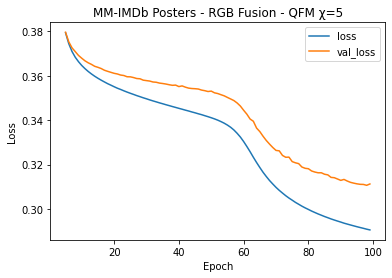

In [ ]:
interval = [ i for i in range(5)]
h_5 = h_5.drop(interval, axis=0)
plt.plot(h_5['loss'], label='loss')
plt.title('MM-IMDb Posters - RGB Fusion - QFM χ=5')
plt.plot(h_5['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

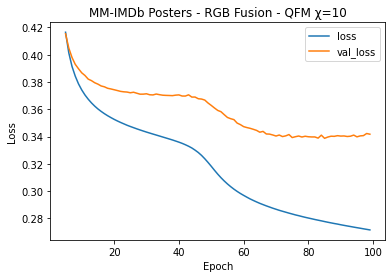

In [ ]:
interval = [ i for i in range(5)]
h_10 = h_10.drop(interval, axis=0)
plt.plot(h_10['loss'], label='loss')
plt.title('MM-IMDb Posters - RGB Fusion - QFM χ=10')
plt.plot(h_10['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

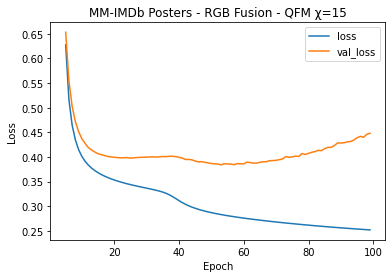

In [ ]:
interval = [ i for i in range(5)]
h_15 = h_15.drop(interval, axis=0)
plt.plot(h_15['loss'], label='loss')
plt.title('MM-IMDb Posters - RGB Fusion - QFM χ=15')
plt.plot(h_15['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

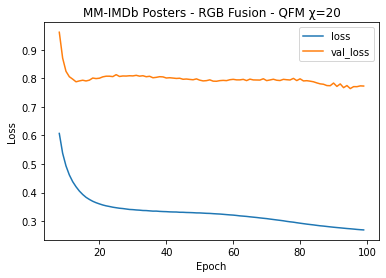

In [ ]:
interval = [ i for i in range(8)]
h_20 = h_20.drop(interval, axis=0)
plt.plot(h_20['loss'], label='loss')
plt.title('MM-IMDb Posters - RGB Fusion - QFM χ=20')
plt.plot(h_20['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

> **Results**

<table>
    <thead>
    <tr>
        <th colspan="5">F-Score</th>
    </tr>
    <tr>
        <th>dataset</th>
        <th>macro</th>
        <th>micro</th>
        <th>weighted</th>
        <th>samples</th>
    </tr>
    </thead>
    <thead>
    <tr>
        <th colspan="5">χ=5</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0288</td>
        <td>0.2433</td>
        <td>0.1407</td>
        <td>0.2381</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.029</td>
        <td>0.2333</td>
        <td>0.1375</td>
        <td>0.2282</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.0285</td>
        <td>0.233</td>
        <td>0.1356</td>
        <td>0.2288</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=10</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0398</td>
        <td>0.2524</td>
        <td>0.1718</td>
        <td>0.2156</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.0531</td>
        <td>0.2183</td>
        <td>0.1666</td>
        <td>0.1895</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.0507</td>
        <td>0.2144</td>
        <td>0.1629</td>
        <td>0.1862</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=15</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.0662</td>
        <td>0.3318</td>
        <td>0.2394</td>
        <td>0.2786</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.1048</td>
        <td>0.2305</td>
        <td>0.2262</td>
        <td>0.2069</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.097</td>
        <td>0.2255</td>
        <td>0.2188</td>
        <td>0.2</td>
    </tr>
    </tbody>
    <thead>
    <tr>
        <th colspan="5">χ=20</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td>train</td>
        <td>0.055</td>
        <td>0.2523</td>
        <td>0.1908</td>
        <td>0.195</td>
    </tr>
    <tr>
        <td>dev</td>
        <td>0.1362</td>
        <td>0.2061</td>
        <td>0.2645</td>
        <td>0.1677</td>
    </tr>
    <tr>
        <td>test</td>
        <td>0.1387</td>
        <td>0.2023</td>
        <td>0.262</td>
        <td>0.1641</td>
    </tr>
    </tbody>
</table>

## MPS for Textual Classification

### English/Spanish Word Classification

#### Data Preprocessing

The data set:

English: The initial data set comes from the 10000 most common words in English data set, from the [Gutenberg project 2006](https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000)

Spanish: The initial data set comes from the 10000 most common words from the  [RAE](http://corpus.rae.es/frec/10000_formas.TXT)

We deleted special characters in both spanish and english and words with less three characters.

After doing the cleaning and deleting the words we have a data set of 19001 words on both spanish and english, 9454 in english and 9547 in spanish

In total we have a training data set of 12730 words, and a testing data set of 6271

In [ ]:
# Data Upload as pandas
git_raw_url_dataset = "https://raw.githubusercontent.com/diegour1/Machine-Learning-2020/master/languages_words_19000.csv"
words_df = pd.read_csv(git_raw_url_dataset)

# Lower case the language column
words_df['Language'] = words_df['Language'].str.lower()
words_df['Language'] = words_df['Language'].str.strip()

print(words_df.shape) #(768, 9)
words_df.head()

(19001, 4)


,Index,Word,Length,Language
0,1,that,4,english
1,2,with,4,english
2,3,which,5,english
3,4,have,4,english
4,5,from,4,english


In [ ]:
# Split the Data as pandas
X = words_df['Word']
y = words_df['Language']

# One hot encode the language
Y = list(y)
Y = np.array([1 if y == 'english' else 0 for y in Y])

# split the data with training and testing
data_train, data_validation, target_train, target_validation = train_test_split(X, Y, test_size=0.33, random_state=42)

data_train.shape , data_validation.shape , target_train.shape , target_validation.shape

((12730,), (6271,), (12730,), (6271,))

In [ ]:
# Apply vectorizer function with diferent ngrams
ngram_min = 2
ngram_max = 2
vectorizer = CountVectorizer(ngram_range = (ngram_min, ngram_max), analyzer = 'char')

# Vectorice the data
X1_train = vectorizer.fit_transform(data_train)
X1_test = vectorizer.transform(data_validation)

X1_train.shape, X1_test.shape

((12730, 464), (6271, 464))

#### N-grams orderings

Here we show various functions to change the ordering of the n-gram

Random ordering

In [ ]:
# Shuffle randomly the columns of X_train
indices = np.arange(X1_train.shape[1])
np.random.shuffle(indices)

X1_train = X1_train[:,indices]
X1_test = X1_test[:,indices]

X1_train.shape, X1_test.shape

Custom order 1

In [ ]:
# Create a list of indices which saves the first type of order of n_grams
features_names = vectorizer.get_feature_names()
letters = ['a', 'b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]

# Create a list of indices which saves an special order of n_grams
indices = []
for i in range(26):
  for j in range(i,26):
    word_ij = ''.join([letters[i], letters[j]])
    word_ji = ''.join([letters[j], letters[i]])
    try:
      indices.append(features_names.index(word_ij))
    except: 
      pass
    if word_ij != word_ji:
      try:
        indices.append(features_names.index(word_ji))
      except:
        pass

len(indices), len(features_names)

(402, 402)

In [ ]:
# Order the n_grams based on the special order of n_grams
X1_train = X1_train[:,indices]
X1_test = X1_test[:,indices]

X1_train.shape, X1_test.shape

Custom Order 2

In [ ]:
# Create a ordering based on the frequency of consecutive n-grams
def generate_order(X, n_gram_range):
  '''
  The following function calc the order of n grams based on frequency
  '''
  vectorizer = CountVectorizer(ngram_range = (n_gram_range, n_gram_range), analyzer = 'char')
  X1 = vectorizer.fit_transform(X)
  vocab = vectorizer.vocabulary_
  n_grams = []
  for key in vocab:
    n_grams.append(key)
  n_grams.sort()
  indexes = {}
  for index, value in enumerate(n_grams):
    indexes[value] = index
  size = len(vocab)
  freqs = np.zeros((size, size))
  
  for word in X:
    for i in range(len(word) - (n_gram_range)):
      current = word[i: i + n_gram_range].lower()
      next = word[i + 1:i + 1 + n_gram_range].lower()
      freqs[indexes[current]][indexes[next]] += 1
  df = pd.DataFrame(freqs, columns=n_grams)
  order = []

  # selecciona el indice con frecuencia mas alta como inicio de ordenamiento
  idx = np.argmax(df.sum(axis=1))
  #idx = 0
  #idx = np.argmin(df.sum(axis=1))
  order.append(df.columns[idx])
  df = df.drop(columns=[df.columns[idx]], axis=1)
  length = df.shape[0]
  while len(order) < length:
    next = np.argmax(df.iloc[idx,:])
    item = df.columns[next] 
    df = df.drop(columns=[item], axis=1)    
    idx = indexes[item]
    order.append(item)
  return order

In [ ]:
generate_order(['carro', 'perra', 'cierto'], 2)

['er', 'rr', 'ra', 'ar', 'ca', 'ci', 'ie', 'pe', 'ro', 'rt', 'to']

In [ ]:
order_by_freq = generate_order(data_train, 2)

In [ ]:
custom_vocabulary = {}
for key, value in enumerate(order_by_freq):
  custom_vocabulary[value] = key

indices = []
for key in vectorizer.vocabulary_:
  indices.append(custom_vocabulary[key])

In [ ]:
# order by custom indexes
X1_train = X1_train[:,indices]
X1_test = X1_test[:,indices]

X1_train.shape, X1_test.shape

((12730, 464), (6271, 464))

Function for chosing three types of ordering (random, custom 2, or alphabetical)

In [ ]:
def order(order_type, X_train_p = X1_train, X_test_p = X1_test):
  
  # Create the custom2 ordering
  if order_type == 'custom1':   
    order_by_freq = generate_order(data_train, 2)

    # create a list of indices of the ordering
    custom_vocabulary = {}
    for key, value in enumerate(order_by_freq):
      custom_vocabulary[value] = key
    indices = []
    for key in vectorizer.vocabulary_:
      indices.append(custom_vocabulary[key])
    # order by custom indexes
    X_train_p = X_train_p[:,indices]
    X_test_p = X_test_p[:,indices]

  # Shuffle randomly the columns of X_train
  elif order_type == 'random':    
    indices = np.arange(X1_train.shape[1])
    np.random.seed(4)
    np.random.shuffle(indices)
    X_train_p = X_train_p[:,indices]
    X_test_p = X_test_p[:,indices]

  # Shuffle in alphabetical order which is the default
  elif order_type == 'alpha':
    pass

  return X_train_p, X_test_p

In [ ]:
# call the ordering of n_grams
X_train, X_test = order('random')

X_train.shape, X_test.shape, X_train[0].sum(), X_train.T[0].sum()

((12730, 464), (6271, 464), 8, 407)

#### Textual feature Map

Preprocess the data with a suitable feature map, a 0 in the n_gram is mapped to $\left|0\right\rangle$ and a 1 in the n_gram to $\left|1\right\rangle$. For example (0,1,1) is mapped to ((1,0),(0,1),(0,1))

In [ ]:
'''
Based on the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
def preprocess_words(x):
  n_data, n_sites = tuple(x.shape)
  x = x.todense()
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  x = tf.cast(tf.math.greater(x, 0.5), dtype=tf.int32)
  return tf.keras.utils.to_categorical(x, 2)

In [ ]:
# Preprocess words and apply the quantum feature map
X_train = preprocess_words(X_train)
X_test = preprocess_words(X_test)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(target_train, 2)
y_test = tf.keras.utils.to_categorical(target_validation, 2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12730, 464, 2), (6271, 464, 2), (12730, 2), (6271, 2))

#### MPS Training



In [ ]:
# Model Parameters
batch_size = 32
num_classes = 2
epochs = 200
# d_bond = 10 # for MPS
num_exps = 3

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# The training is done on multiple bonds, and multiple experiments per bond
print('randomOrder')
bonds = [2, 4, 8, 16, 32]
# bonds = [10, 20, 30, 40, 50, 60]

# Create numpy arrays to keep track of data
num_points = len(bonds)
train_acc = np.zeros((num_points, num_exps))
test_acc = np.zeros((num_points, num_exps))

for i in range(num_exps):
  for j in range(num_points):
    init_time = time()
    # Define model
    n_sites = X1_train.shape[1]
    model = Sequential()
    model.add(MPSLayer(n_sites=n_sites, d_bond=bonds[j], n_output=num_classes))
    model.add(layers.Softmax())

    # Compile and run
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      validation_data=(X_test, y_test))
    score_test = model.evaluate(X_test, y_test, verbose=0)
    score_train = model.evaluate(X_train, y_train, verbose=0)

    print(bonds[j])
    print('Train accuracy:', score_train[1])
    print('Test accuracy:', score_test[1])
    train_acc[j,i] = score_train[1]
    test_acc[j,i] = score_test[1]

    print(time()-init_time)

# Save the average accuracies and standard deviations in three lists
ave_train_acc = train_acc.mean(axis=1).tolist()
ave_test_acc = test_acc.mean(axis=1).tolist()
std_train_acc = train_acc.std(axis=1).tolist()
std_test_acc = test_acc.std(axis=1).tolist()

randomOrder
2
Train accuracy: 0.7594658136367798
Test accuracy: 0.7523521184921265
935.6121683120728
4
Train accuracy: 0.833385705947876
Test accuracy: 0.8239515423774719
2245.6878061294556


#### **Summary of Results**

Unigrams

In [ ]:
# potencias de 2
# results custom order for (2, 4, 8, 16, 32) unigrams
bonds = [2, 4, 8, 16, 32]
train_acc_custom_unigram = [0.6934013962745667, 0.7005499005317688, 0.7136685252189636, 0.7212883234024048, 0.7270227670669556]
test_acc_custom_unigram = [0.6966990828514099, 0.7027587294578552, 0.7136023044586182, 0.724126935005188, 0.7277945876121521]

# results random order for (2, 4, 8, 16, 32) unigrams

train_acc_random_unigram = [0.6935585141181946, 0.7019638419151306, 0.7151610255241394, 0.7219952940940857, 0.7271798849105835]
test_acc_random_unigram = [0.6992505192756653, 0.7080210447311401, 0.7153564095497131, 0.7246053218841553, 0.7252432107925415]

In [ ]:
# results custom order for (10, 20, 30, 40, 50, 60) unigrams 
bonds = [10, 20, 30, 40, 50, 60]
train_acc_custom_unigram = [0.7179890275001526, 0.7236449122428894, 0.7270227670669556, 0.728829562664032, 0.7304006218910217, 0.7322859168052673]
test_acc_custom_unigram = [0.7196619510650635, 0.7254026532173157, 0.7265188694000244, 0.7285919189453125, 0.7289108633995056, 0.7293892502784729]

# results random order for (10, 20, 30, 40, 50, 60) unigrams
train_acc_random_unigram = [0.7161822319030762, 0.7223880887031555, 0.7265514731407166, 0.7278868556022644, 0.7298507690429688, 0.7321288585662842]
test_acc_random_unigram = [0.7175889015197754, 0.7246053218841553, 0.7265188694000244, 0.7277945876121521, 0.7290703058242798, 0.7301865816116333] 

Bigrams

Potencias de 2

In [ ]:
# potencias de 2 bigram

# results custom order for (2, 4, 8, 16, 32)
bonds = [2, 4, 8, 16, 32]
train_acc_custom_bigram = [0.8019638657569885, 0.8352710008621216, 0.8721916675567627, 0.8845247626304626, 0.8945797085762024]
test_acc_custom_bigram = [0.791580319404602, 0.8352735042572021, 0.8630202412605286, 0.8738638162612915, 0.8826343417167664]

# results random order for (2, 4, 8, 16, 32)
train_acc_random_bigram = [0.7926944494247437, 0.8355852365493774, 0.8725059032440186, 0.8650432229042053, 0.8969363570213318]
test_acc_random_bigram = [0.7867963910102844, 0.8234731554985046, 0.8604688048362732, 0.8623824119567871, 0.8821559548377991]

# results alpha order for (2, 4, 8, 16, 32)
train_acc_alpha_bigram = [0.8021209836006165, 0.8371562957763672, 0.8745483160018921, 0.8787902593612671, 0.8967792391777039]
test_acc_alpha_bigram = [0.793334424495697, 0.8273002505302429, 0.8598309755325317, 0.872747540473938, 0.8810396790504456]

# results custom2 order for (2, 4, 8, 16, 32)
train_acc_custom2_bigram =[0.7904163599014282, 0.8453260064125061, 0.8698350191116333, 0.8835821151733398, 0.8923016786575317]
test_acc_custom2_bigram = [0.7872747778892517, 0.8344761729240417, 0.8593525886535645, 0.872747540473938, 0.8773720264434814]

Multiples of 10

In [ ]:
# Multiples of 10 bigram

# results custom order for (10, 20, 30, 40, 50, 60)
bonds = [10, 20, 30, 40, 50, 60]
train_acc_custom_bigram = [0.8670070767402649, 0.8835035562515259, 0.8919874429702759, 0.8941869735717773, 0.9026708602905273, 0.9245090484619141]
test_acc_custom_bigram = [0.8590336441993713, 0.870993435382843, 0.8794450759887695, 0.8842290043830872, 0.8880561590194702, 0.892999529838562]

# results random order for (10, 20, 30, 40, 50, 60)
train_acc_random_bigram = [0.8778476119041443, 0.8579732775688171, 0.8926944136619568, 0.8695993423461914, 0.8804398775100708, 0.9177533388137817]
test_acc_random_bigram = [0.8657311201095581, 0.8556848764419556, 0.8811991810798645, 0.8631797432899475, 0.8716313242912292, 0.8904480934143066]

# results alpha order for (10, 20, 30, 40, 50, 60)
train_acc_alpha_bigram = [0.8692066073417664, 0.8773762583732605, 0.891123354434967, 0.9018067717552185, 0.9101335406303406, 0.9197171926498413]
test_acc_alpha_bigram = [0.8609471917152405, 0.8722691535949707, 0.8788071870803833, 0.8872588276863098, 0.8870993256568909, 0.8945941925048828]

# results custom2 order for (10, 20, 30, 40, 50, 60)
train_acc_custom2_bigram = [0.8695208430290222, 0.8811469078063965, 0.8937941789627075, 0.9018067717552185, 0.9084839224815369, 0.9007070064544678]
test_acc_custom2_bigram = [0.8647743463516235, 0.8698772192001343, 0.8815181255340576, 0.8877372145652771, 0.8890129327774048, 0.8717907667160034]

Text(0, 0.5, 'Final Accuracy')

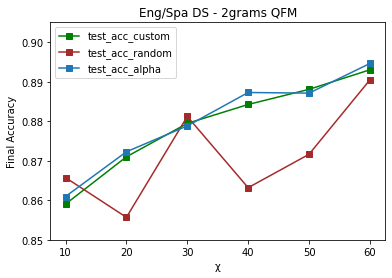

In [ ]:
# plt.figure(figsize=(10, 7))
plt.plot( bonds, test_acc_custom_bigram, label='test_acc_custom', color='green', marker = 's')
plt.title('Eng/Spa DS - 2grams QFM')
plt.plot( bonds, test_acc_random_bigram, label='test_acc_random', color='brown', marker='s')
plt.plot( bonds, test_acc_alpha_bigram, label='test_acc_alpha', marker='s')
#plt.plot( bonds, test_acc_custom2_bigram , label='test_acc_custom2', color='brown', marker='s')
plt.legend()
plt.ylim(0.85, .905)
plt.xlabel('χ')
# plt.semilogx(basex=2)
plt.ylabel('Final Accuracy')

Text(0, 0.5, 'Final Accuracy')

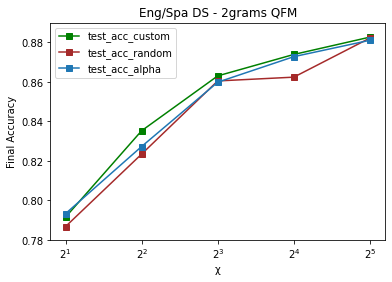

In [ ]:
# plt.figure(figsize=(10, 7))
plt.plot( bonds, test_acc_custom_bigram, label='test_acc_custom', color='green', marker = 's')
plt.title('Eng/Spa DS - 2grams QFM')
plt.plot( bonds, test_acc_random_bigram, label='test_acc_random', color='brown', marker='s')
plt.plot( bonds, test_acc_alpha_bigram, label='test_acc_alpha', marker='s')
# plt.plot( bonds, test_acc_custom2_bigram , label='test_acc_custom2_bigram ', color='brown', marker='s')
plt.legend()
plt.ylim(0.78, .89)
plt.xlabel('χ')
plt.semilogx(basex=2)
plt.ylabel('Final Accuracy')

Summary of results of 10 experiments per points for custom and random orders

In [ ]:
## test accuracy custom
bonds = [2, 4, 8, 16, 32]
test_acc_custom = np.array([[0.76909584, 0.770531  , 0.78312868, 0.75745493, 0.77738798, 0.77499604, 0.75649816, 0.78265029, 0.78599906, 0.80051029],
       [0.83080846, 0.83479512, 0.82634348, 0.81757295, 0.82985169, 0.84420347, 0.8333599 , 0.82442993, 0.82841653, 0.82889491],
       [0.8587147 , 0.86030936, 0.85823631, 0.85839581, 0.86206347, 0.86413652, 0.8571201 , 0.85983098, 0.85775793, 0.85424972],
       [0.86365813, 0.87195027, 0.86668795, 0.87226915, 0.87418276, 0.87067455, 0.87290704, 0.87019616, 0.87131238, 0.87019616],
       [0.87928557, 0.87402326, 0.87816936, 0.87992346, 0.87785041, 0.88311273, 0.87609631, 0.87880719, 0.87785041, 0.87992346]])

ave_test_acc_custom = test_acc_custom.mean(axis=1).tolist()
std_test_acc_custom = test_acc_custom.std(axis=1).tolist()

test_acc_custom.shape, ave_test_acc_custom, std_test_acc_custom

((5, 10),
 [0.775825227,
  0.8298676440000001,
  0.85908149,
  0.8704034549999999,
  0.878504216],
 [0.012650010638481724,
  0.006626289137612694,
  0.0025841597736169473,
  0.00294473266973166,
  0.0022981132861554145])

In [ ]:
## test accuracy random

test_acc_random = np.array([[0.76813906, 0.76191998, 0.76574707, 0.79397225, 0.77132833, 0.7788231372833252, 0.7523521184921265, 0.76766068, 0.76223886, 0.76829851 ],
       [0.81980544, 0.82873547, 0.82331365, 0.83623028, 0.83128685, 0.8253867030143738, 0.8239515423774719, 0.8212406 , 0.82745975, 0.82618403],
       [0.86030936, 0.85967153, 0.85743898, 0.85664171, 0.86365813, 0.8553659915924072, 0.8587146997451782, 0.86142564, 0.85999042, 0.85903364],
       [0.87195027, 0.87322599, 0.87179077, 0.87115294, 0.86971778, 0.8614256381988525, 0.8729070425033569, 0.86238241, 0.86971778, 0.87099344],
       [0.87641525, 0.8767342 , 0.87402326, 0.88088024, 0.88215595, 0.8811991810798645, 0.8792855739593506, 0.88103968, 0.88550472, 0.88295329]])

ave_test_acc_random = test_acc_random.mean(axis=1).tolist()
std_test_acc_random = test_acc_random.std(axis=1).tolist()

test_acc_random.shape, ave_test_acc_random, std_test_acc_random

((5, 10),
 [0.7690479995775452,
  0.8263594315391846,
  0.8592250101337585,
  0.8695264060702209,
  0.8800191345039214],
 [0.010545642089011025,
  0.004623616385596519,
  0.0022695545154592855,
  0.003970494344512589,
  0.003266646954180394])

Text(0, 0.5, 'Final Accuracy')

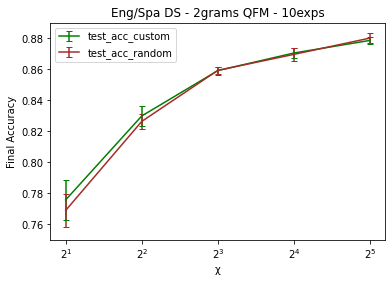

In [ ]:
# plt.figure(figsize=(6,4))
# plt.plot( bonds, ave_test_acc_custom, label='test_acc_custom', color='green', marker = 's')
plt.errorbar(bonds, ave_test_acc_custom, yerr=std_test_acc_custom, capsize=3, label='test_acc_custom', color='green')
plt.title('Eng/Spa DS - 2grams QFM - 10exps')
# plt.plot( bonds, ave_test_acc_random, label='test_acc_random', color='red', marker='s')
plt.errorbar(bonds, ave_test_acc_random, yerr=std_test_acc_random, capsize=3, label='test_acc_random', color='brown')
# plt.plot( bonds, test_acc_alpha_bigram, label='test_acc_alpha_bigram', color='green', marker='s')
# plt.plot( bonds, test_acc_custom2_bigram , label='test_acc_custom2_bigram ', color='brown', marker='s')
plt.legend()
plt.ylim(0.75, .89)
plt.xlabel('χ')
plt.semilogx(basex=2)
plt.ylabel('Final Accuracy')

#### Comparison with SVM



We consider 2-grams to create the vectorizer histogram representation kernel.

In [ ]:
# Apply vectorizer function with diferent ngrams
ngram_min = 2
ngram_max = 2
vectorizer = CountVectorizer(ngram_range = (ngram_min, ngram_max), analyzer = 'char')

# Vectorice the data
X1_train = vectorizer.fit_transform(data_train)
X1_test = vectorizer.transform(data_validation)

X1_train.shape, X1_test.shape

((12730, 464), (6271, 464))

 Function of the histogram Kernel

In [ ]:
# Apply Histogram Kernel Function
def histogram_kernel(X_p, X_p2):
  N1 = X_p/np.sum(X_p, axis=1).reshape(-1, 1)
  N2 = X_p2/np.sum(X_p2, axis=1).reshape(-1, 1)
  K2_a = np.zeros((N1.shape[0], N2.shape[0]))
  for d in range(N1.shape[1]):
    column_1 = N1[:, d].reshape(-1, 1)
    column_2 = N2[:, d].reshape(-1, 1)
    K2_a += np.minimum(column_1, column_2.T)   
  return K2_a 

In [ ]:
# Example
histogram_kernel(np.array([[0.2, 0.3],[0.1, 0.4],[0.3,0.2]]), np.array([[0.2, 0.3],[0.1, 0.4]]))

array([[1. , 0.8],
       [0.8, 1. ],
       [0.8, 0.6]])

In [ ]:
# Train the histogram kernel
clf = svm.SVC(C=4.0, kernel=histogram_kernel)
clf.fit(X1_train, target_train)

SVC(C=4.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function histogram_kernel at 0x7f6d374589d8>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
pred = clf.predict(X1_test)

In [ ]:
nt = len(target_validation)
errors = np.sum(pred != target_validation)
accuracy = 1-(errors/nt)
accuracy

0.8762557805772604

The SVM obtains 87.62 % accuracy on test data on 2grams, the MPS tensor network obtains 89.45 % accuacy on test data on 2grams with a bond of $\chi=60$. Hence the MPS tensor network outperforms the SVM.

### MM-IMDb Plots Tidif QFM

In [ ]:
# Extract the sequences and genres of Train Google Drive
train_three_grams = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('train',), sources = ['three_grams'], load_in_memory=True)
train_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('train',), sources = ['genres'], load_in_memory=True)
# Extract the sequences and genres of Validation ('dev') 
validation_three_grams = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['three_grams'], load_in_memory=True)
validation_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['genres'], load_in_memory=True)
# Extract the sequences and genres of Test
test_three_grams = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('test',), sources = ['three_grams'], load_in_memory=True)
test_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('test',), sources = ['genres'], load_in_memory=True)

# # Extract the sequences and genres of Train PaperSpace
# train_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('train',), sources = ['sequences'], load_in_memory=True)
# train_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('train',), sources = ['genres'], load_in_memory=True)
# # Extract the sequences and genres of Validation ('dev') 
# validation_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['sequences'], load_in_memory=True)
# validation_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['genres'], load_in_memory=True)
# # Extract the sequences and genres of Test
# test_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('test',), sources = ['sequences'], load_in_memory=True)
# test_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('test',), sources = ['genres'], load_in_memory=True)

Request the data out of the fuel

In [ ]:
# Save the data in six variables
X_train, = train_three_grams.data_sources
X_validation, = validation_three_grams.data_sources
X_test, = test_three_grams.data_sources
y_train, = train_genres.data_sources
y_validation, = validation_genres.data_sources
y_test, = test_genres.data_sources

X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((15552, 9946),
 (2608, 9946),
 (7799, 9946),
 (15552, 23),
 (2608, 23),
 (7799, 23))

Apply the feature Map

In [ ]:
'''
Based on the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# Find the average value of non zero values of the Tifdf vector, choose ket(0)
# for values below the average ket(1) for n-grams above the average
def preprocess_words(X_p):
  n_data, n_sites = tuple(X_p.shape)
  #x = x.todense()
  average = X_p.sum(axis=1)/np.count_nonzero(X_p, axis=1)
  average = tf.convert_to_tensor(average, dtype=tf.float32)
  average = tf.keras.backend.reshape(average, shape=(-1, 1))
  X_p = tf.convert_to_tensor(X_p, dtype=tf.float32)
  X_p = tf.cast(tf.math.greater(X_p, average), dtype=tf.int32)
  return tf.keras.utils.to_categorical(X_p, 2)

In [ ]:
# Preprocess words and apply the quantum feature map
X_train = preprocess_words(X_train)
X_validation = preprocess_words(X_validation)
X_test = preprocess_words(X_test)

X_train.shape, X_validation.shape, X_test.shape

((15552, 9946, 2), (2608, 9946, 2), (7799, 9946, 2))

Model with MPS layer for the Classification 

In [ ]:
# Model Parameters
batch_size = 32
num_classes = 23
epochs = 200
d_bond = 10 # for MPS

In [ ]:
'''
Taken from the notebook mps_mnist.ipynb from Stavros Efthymiou and https://arxiv.org/pdf/1906.06329.pdf
'''
# Define model
n_sites = X_train.shape[1]
model = Sequential()
model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
model.add(layers.Activation(activations.sigmoid))


# Compile and run
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_validation, y_validation))
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# evaluates the model over a data set returning the 4 types of f-scores
def evaluate_model(X_p, y_p, model_p = model):
  # compute the prediction of the model
  y_pred = model_p.predict(X_p)
  y_pred[y_pred>=0.5] = 1
  y_pred[y_pred<0.5] = 0

  # compute the 4 types of f scores
  f_macro = f1_score(y_p, y_pred, average='macro').round(3)
  f_micro = f1_score(y_p, y_pred, average='micro').round(3)
  f_weighted = f1_score(y_p, y_pred, average='weighted').round(3)
  f_samples = f1_score(y_p, y_pred, average='samples').round(3)

  return (f_macro, f_micro, f_weighted, f_samples)

In [ ]:
evaluate_model(X_train, y_train)

(0.217, 0.472, 0.416, 0.415)

In [ ]:
evaluate_model(X_test, y_test)

(0.17, 0.387, 0.338, 0.344)

In [ ]:
evaluate_model(X_validation, y_validation)

(0.169, 0.389, 0.339, 0.351)

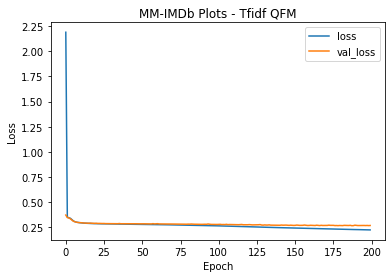

In [ ]:
plot_and_save_loss(history.history, 'MM-IMDb Plots - Tfidf QFM')

#### **Results**

The bond of the MPS is 10, We choosed the feature map based on Tidif, the results are summarized in the following table.

|||**F-Score: MPS Tfidf QFM, bond=10**|||
| :-- | :---: | :---:| :---: | :---: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.217|0.472|0.416|0.415| 
|**Dev**|0.17|0.387|0.338| 0.344|
|**Test**|0.169| 0.389|0.339|0.351|

The results compared on **Test** data set on our **MPS Tfidf** model with respect to a **LSTM w2v** model, 

|||**F-Score: Test dataset** |||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**MPS Tfidf**|0.169| 0.389|0.339|0.351|
|**LSTM w2v**|0.266| 0.478|0.434|0.471|

